# Практическая работа №3
### Королев Павел Александрович
## Цель:
Получение навыков решения задачи классификации с помощью языка программирования Python.

### Ход работы
1. обработка исходных данных, замена огибочных значений на средннее по столбцу
2. вывод корреляционной таблицы
3. исключение слабокоррелирующих признаков
4. приведение данных к понятному для модели виду через OneHotEncoding
5. тестирование различных моделей
6. создание Submission

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings("ignore")

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [2]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

In [3]:
train.head()

id  ClientPeriod  MonthlySpending TotalSpent     Sex  IsSeniorCitizen  \
0  4719            28            20.30     487.95    Male                0   
1  3190            12            81.45        912    Male                0   
2  5215            25            20.15     536.35    Male                0   
3  1472            50            69.50     3418.2    Male                0   
4  4413            39           101.25    3949.15  Female                1   

  HasPartner HasChild HasPhoneService HasMultiplePhoneNumbers  ...  \
0        Yes      Yes             Yes                      No  ...   
1         No       No             Yes                      No  ...   
2         No       No             Yes                      No  ...   
3         No       No             Yes                     Yes  ...   
4        Yes       No             Yes                     Yes  ...   

  HasOnlineSecurityService      HasOnlineBackup  HasDeviceProtection  \
0      No internet service  No internet service  No internet service   
1                       No                   No                   No   
2      No internet service  No internet service  No internet service   
3                       No                   No                  Yes   
4                       No                   No                   No   

  HasTechSupportAccess          HasOnlineTV HasMovieSubscription  \
0  No internet service  No internet service  No internet service   
1                   No                  Yes                   No   
2  No internet service  No internet service  No internet service   
3                  Yes                   No                  Yes   
4                  Yes                  Yes                  Yes   

  HasContractPhone IsBillingPaperless              PaymentMethod Churn  
0         Two year                Yes    Credit card (automatic)     0  
1   Month-to-month                Yes           Electronic check     0  
2   Month-to-month                Yes               Mailed check     0  
3         Two year                 No  Bank transfer (automatic)     0  
4   Month-to-month                Yes           Electronic check     0  

[5 rows x 21 columns]

In [4]:
test.head()

id  ClientPeriod  MonthlySpending TotalSpent     Sex  IsSeniorCitizen  \
0  2258            46            55.65    2688.85  Female                0   
1  3864            48            78.75    3682.45    Male                0   
2  1391             7            69.20     477.55  Female                0   
3   486             3            75.15     216.75  Female                0   
4   970            14            19.35      324.8    Male                0   

  HasPartner HasChild HasPhoneService HasMultiplePhoneNumbers  \
0         No       No             Yes                      No   
1         No      Yes             Yes                     Yes   
2        Yes       No             Yes                      No   
3        Yes       No             Yes                     Yes   
4         No       No             Yes                      No   

  HasInternetService HasOnlineSecurityService      HasOnlineBackup  \
0                DSL                       No                   No   
1                DSL                      Yes                   No   
2        Fiber optic                       No                   No   
3        Fiber optic                       No                   No   
4                 No      No internet service  No internet service   

   HasDeviceProtection HasTechSupportAccess          HasOnlineTV  \
0                   No                   No                   No   
1                  Yes                   No                  Yes   
2                   No                   No                   No   
3                   No                   No                   No   
4  No internet service  No internet service  No internet service   

  HasMovieSubscription HasContractPhone IsBillingPaperless  \
0                  Yes         One year                 No   
1                  Yes         One year                Yes   
2                   No   Month-to-month                Yes   
3                   No   Month-to-month                Yes   
4  No internet service         One year                 No   

               PaymentMethod  
0    Credit card (automatic)  
1    Credit card (automatic)  
2  Bank transfer (automatic)  
3    Credit card (automatic)  
4               Mailed check

In [5]:
train.describe()

id  ClientPeriod  MonthlySpending  IsSeniorCitizen  \
count  3169.000000   3169.000000      3169.000000      3169.000000   
mean   2658.504891     31.855790        65.157715         0.162512   
std    1536.114959     24.471827        29.921808         0.368978   
min       1.000000      0.000000        18.250000         0.000000   
25%    1330.000000      8.000000        39.200000         0.000000   
50%    2635.000000     28.000000        70.700000         0.000000   
75%    4027.000000     54.000000        89.850000         0.000000   
max    5279.000000     72.000000       118.650000         1.000000   

             Churn  
count  3169.000000  
mean      0.265068  
std       0.441439  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000

In [6]:
def fix_columns(in_data):
    tmp1 = in_data.TotalSpent
    tmp1 = np.array(tmp1)
    tmp2 = in_data.IsSeniorCitizen
    tmp2 = np.array(tmp2)
    try:
        tmp3 = in_data.Churn
    except:
        pass
    TotalSpent = []
    IsSeniorCitizen = []
    Churn = []
    
    for i in range(0, len(tmp1)):
        try:
            TotalSpent.append(float(tmp1[i]))
        except:
            TotalSpent.append(np.nan)
        try:
            IsSeniorCitizen.append(bool(tmp2[i]))
        except:
            IsSeniorCitizen.append(bool(np.nan))
        try:
            Churn.append(bool(tmp3[i]))
        except:
            Churn.append(np.nan)   
            
    df = pd.DataFrame({'TotalSpent': TotalSpent})
    mean = df.dropna().mean()
    TotalSpent = []
    
    for i in range(0, len(tmp1)):
        try:
            TotalSpent.append(float(tmp1[i]))
        except:
            TotalSpent.append(float(mean))
            
    df = pd.DataFrame({'TotalSpent': TotalSpent})
    in_data.TotalSpent = df
    df = pd.DataFrame({'IsSeniorCitizen': IsSeniorCitizen})
    in_data.IsSeniorCitizen = df
    df = pd.DataFrame({'Churn': Churn})
    try:
        in_data.Churn = df
    except:
        pass
    
    return in_data

def ohe_fix(in_data):
    cat_cols = [
                'Sex',
                'HasPartner',
                'HasChild',
                'HasPhoneService',
                'HasMultiplePhoneNumbers',
                'HasInternetService',
                'HasOnlineSecurityService',
                'HasOnlineBackup',
                'HasDeviceProtection',
                'HasTechSupportAccess',
                'HasOnlineTV',
                'HasMovieSubscription',
                'HasContractPhone',
                'IsBillingPaperless',
                'PaymentMethod'
               ]  
    num_cols = [
                'ClientPeriod',
                'MonthlySpending',
                'IsSeniorCitizen',
                'TotalSpent'
                ]
    
    features = pd.DataFrame()
    for k in cat_cols:
        ohe = OneHotEncoder()
        encoded = ohe.fit_transform(in_data[k].values.reshape(-1,1))
        tmp = pd.DataFrame(encoded.toarray(), columns=[k + str(i) for i in range(encoded.shape[1])])
        features = pd.concat([features, tmp], axis=1)
    train_out = pd.DataFrame()
    train_out = pd.concat([in_data[num_cols], features], axis=1)
    
    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(in_data[num_cols])
    train_out[num_cols] = scaled_values 
    
    return train_out

In [7]:
# Числовые признаки
num_cols = [
            'ClientPeriod',
            'MonthlySpending',
            'IsSeniorCitizen',
            'TotalSpent'
            ]

cat_cols = [
                'Sex',
                'HasPartner',
                'HasChild',
                'HasPhoneService',
                'HasMultiplePhoneNumbers',
                'HasInternetService',
                'HasOnlineSecurityService',
                'HasOnlineBackup',
                'HasDeviceProtection',
                'HasTechSupportAccess',
                'HasOnlineTV',
                'HasMovieSubscription',
                'HasContractPhone',
                'IsBillingPaperless',
                'PaymentMethod'
            ] 

feature_cols = num_cols
target_col = 'Churn'

In [8]:
x = train[num_cols]
y = train[target_col]
total_rows = len(train.index)

# Приведение к нормальному виду

In [9]:
new_train = ohe_fix(fix_columns(train))
new_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3169 entries, 0 to 3168
Data columns (total 45 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ClientPeriod               3169 non-null   float64
 1   MonthlySpending            3169 non-null   float64
 2   IsSeniorCitizen            3169 non-null   float64
 3   TotalSpent                 3169 non-null   float64
 4   Sex0                       3169 non-null   float64
 5   Sex1                       3169 non-null   float64
 6   HasPartner0                3169 non-null   float64
 7   HasPartner1                3169 non-null   float64
 8   HasChild0                  3169 non-null   float64
 9   HasChild1                  3169 non-null   float64
 10  HasPhoneService0           3169 non-null   float64
 11  HasPhoneService1           3169 non-null   float64
 12  HasMultiplePhoneNumbers0   3169 non-null   float64
 13  HasMultiplePhoneNumbers1   3169 non-null   float

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3169 entries, 0 to 3168
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        3169 non-null   int64  
 1   ClientPeriod              3169 non-null   int64  
 2   MonthlySpending           3169 non-null   float64
 3   TotalSpent                3169 non-null   float64
 4   Sex                       3169 non-null   object 
 5   IsSeniorCitizen           3169 non-null   bool   
 6   HasPartner                3169 non-null   object 
 7   HasChild                  3169 non-null   object 
 8   HasPhoneService           3169 non-null   object 
 9   HasMultiplePhoneNumbers   3169 non-null   object 
 10  HasInternetService        3169 non-null   object 
 11  HasOnlineSecurityService  3169 non-null   object 
 12  HasOnlineBackup           3169 non-null   object 
 13  HasDeviceProtection       3169 non-null   object 
 14  HasTechS

In [11]:
num_cols_2 = [
    'ClientPeriod',
    'MonthlySpending',
    'IsSeniorCitizen',
    'TotalSpent',
    'Sex0',
    'Sex1',
    'HasPartner0',
    'HasPartner1',
    'HasChild0',
    'HasChild1',
    'HasPhoneService0',
    'HasPhoneService1',
    
    'HasMultiplePhoneNumbers0',
    'HasMultiplePhoneNumbers1',
    'HasMultiplePhoneNumbers2',
    'HasInternetService0',
    'HasInternetService1',
    'HasInternetService2',
    'HasOnlineSecurityService0',
    'HasOnlineSecurityService1',
    'HasOnlineSecurityService2',
    'HasOnlineBackup0',
    'HasOnlineBackup1',
    'HasOnlineBackup2',
    'HasDeviceProtection0',
    'HasDeviceProtection1',
    'HasDeviceProtection2',
    'HasTechSupportAccess0',
    'HasTechSupportAccess1',
    'HasTechSupportAccess2',
    'HasOnlineTV0',
    'HasOnlineTV1',
    'HasOnlineTV2',
    'HasMovieSubscription0',
    'HasMovieSubscription1',
    'HasMovieSubscription2',
    'HasContractPhone0',
    'HasContractPhone1',
    'HasContractPhone2',
    
    'IsBillingPaperless0',
    'IsBillingPaperless1',
    'PaymentMethod0',
    'PaymentMethod1',
    'PaymentMethod2',
    'PaymentMethod3'
]

cat_cols = [
    'Sex',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]


feature_cols = num_cols
target_col = 'Churn'

# Обучение

In [12]:
new_train

ClientPeriod  MonthlySpending  IsSeniorCitizen  TotalSpent  Sex0  Sex1  \
0         0.388889         0.020418              0.0    0.054126   0.0   1.0   
1         0.166667         0.629482              0.0    0.103059   0.0   1.0   
2         0.347222         0.018924              0.0    0.059711   0.0   1.0   
3         0.694444         0.510458              0.0    0.392262   0.0   1.0   
4         0.541667         0.826693              1.0    0.453531   1.0   0.0   
...            ...              ...              ...         ...   ...   ...   
3164      0.027778         0.614542              0.0    0.017950   0.0   1.0   
3165      0.222222         0.553785              0.0    0.146009   0.0   1.0   
3166      0.694444         0.518924              1.0    0.396462   0.0   1.0   
3167      0.750000         0.366036              0.0    0.354695   0.0   1.0   
3168      0.194444         0.603586              1.0    0.118268   1.0   0.0   

      HasPartner0  HasPartner1  HasChild0  HasChild1  ...  \
0             0.0          1.0        0.0        1.0  ...   
1             1.0          0.0        1.0        0.0  ...   
2             1.0          0.0        1.0        0.0  ...   
3             1.0          0.0        1.0        0.0  ...   
4             0.0          1.0        1.0        0.0  ...   
...           ...          ...        ...        ...  ...   
3164          1.0          0.0        1.0        0.0  ...   
3165          0.0          1.0        1.0        0.0  ...   
3166          1.0          0.0        1.0        0.0  ...   
3167          1.0          0.0        0.0        1.0  ...   
3168          1.0          0.0        1.0        0.0  ...   

      HasMovieSubscription2  HasContractPhone0  HasContractPhone1  \
0                       0.0                0.0                0.0   
1                       0.0                1.0                0.0   
2                       0.0                1.0                0.0   
3                       1.0                0.0                0.0   
4                       1.0                1.0                0.0   
...                     ...                ...                ...   
3164                    0.0                1.0                0.0   
3165                    0.0                1.0                0.0   
3166                    0.0                1.0                0.0   
3167                    0.0                1.0                0.0   
3168                    0.0                1.0                0.0   

      HasContractPhone2  IsBillingPaperless0  IsBillingPaperless1  \
0                   1.0                  0.0                  1.0   
1                   0.0                  0.0                  1.0   
2                   0.0                  0.0                  1.0   
3                   1.0                  1.0                  0.0   
4                   0.0                  0.0                  1.0   
...                 ...                  ...                  ...   
3164                0.0                  0.0                  1.0   
3165                0.0                  0.0                  1.0   
3166                0.0                  0.0                  1.0   
3167                0.0                  0.0                  1.0   
3168                0.0                  1.0                  0.0   

      PaymentMethod0  PaymentMethod1  PaymentMethod2  PaymentMethod3  
0                0.0             1.0             0.0             0.0  
1                0.0             0.0             1.0             0.0  
2                0.0             0.0             0.0             1.0  
3                1.0             0.0             0.0             0.0  
4                0.0             0.0             1.0             0.0  
...              ...             ...             ...             ...  
3164             0.0             0.0             1.0             0.0  
3165             1.0             0.0             0.0             0.0  
3166           

In [13]:
x = new_train[num_cols_2]
y = train[target_col]

In [14]:
train.isna().sum()

id                          0
ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

In [15]:
x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=0.80)

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

## GradientBoostingClassifier

In [17]:
grad = GradientBoostingClassifier(loss='deviance', criterion = 'friedman_mse', n_estimators=50, subsample=0.8, learning_rate=0.1, max_features = 'log2')

In [18]:
grad.fit(x_train, y_train)

GradientBoostingClassifier(max_features='log2', n_estimators=50, subsample=0.8)

In [19]:
y_train_predicted_grad = grad.predict_proba(x_train)[:, 1]
y_val_predicted_grad = grad.predict_proba(x_val)[:, 1]

In [20]:
def roc_auc_plot(y_train, y_train_predicted, y_val, y_val_predicted):
    train_auc = roc_auc_score(y_train, y_train_predicted)
    test_auc = roc_auc_score(y_val, y_val_predicted)

    plt.figure(figsize=(10,7))
    plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
    plt.plot(*roc_curve(y_val, y_val_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
    legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
    legend_box.set_facecolor("white")
    legend_box.set_edgecolor("black")
    plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
    plt.show()

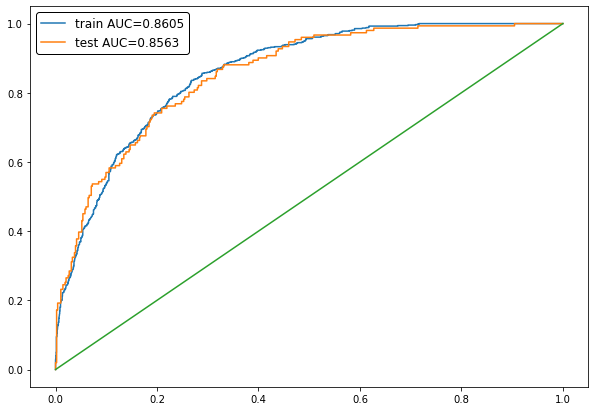

In [21]:
roc_auc_plot(y_train, y_train_predicted_grad, y_val, y_val_predicted_grad)

## KNN

In [22]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

KNeighborsClassifier()

In [23]:
y_train_predicted_knn = knn.predict_proba(x_train)[:, 1]
y_val_predicted_knn = knn.predict_proba(x_val)[:, 1]

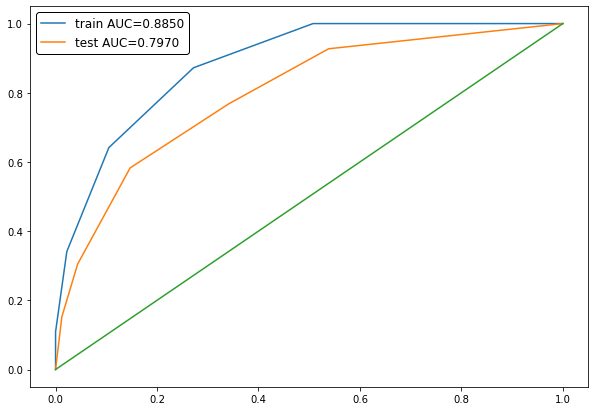

In [24]:
roc_auc_plot(y_train, y_train_predicted_knn, y_val, y_val_predicted_knn)

## XGBClassifier

In [25]:
xgbc = XGBClassifier()
x_train_gbc = []

In [26]:
xgbc.fit(x_train, y_train)

# x_xgbc

[10:51:15] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [27]:
y_train_predicted_xgbc = xgbc.predict_proba(x_train)[:, 1]
y_val_predicted_xgbc = xgbc.predict_proba(x_val)[:, 1]

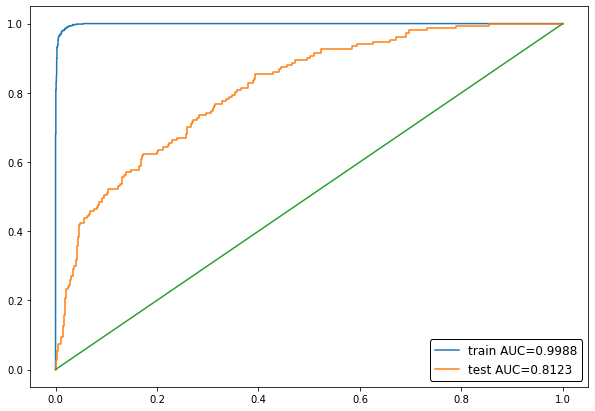

In [28]:
roc_auc_plot(y_train, y_train_predicted_xgbc, y_val, y_val_predicted_xgbc)

### А почему так...

In [29]:
xgbc = XGBClassifier()
x_train_gbc = []

xgbc_train = []

for i in range(total_rows):
    xgbc_train.append([new_train.loc[i].tolist()])

x_xgbc = xgbc_train
y_xgbc = train[target_col].values.tolist()
    
x_train_gbc, x_val_gbc, y_train_gbc, y_val_gbc = train_test_split(x, y, train_size=0.80)
xgbc.fit(x_train_gbc, y_train_gbc)

[10:51:16] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [30]:
y_train_predicted_xgbc = xgbc.predict_proba(x_train)[:, 1]
y_val_predicted_xgbc = xgbc.predict_proba(x_val)[:, 1]

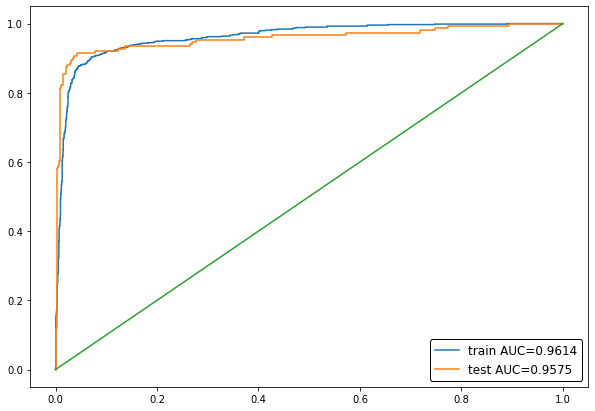

In [31]:
roc_auc_plot(y_train, y_train_predicted_xgbc, y_val, y_val_predicted_xgbc)

## GradientBoostingRegressor

In [32]:
from sklearn.ensemble import GradientBoostingRegressor

In [33]:
grad_r = GradientBoostingRegressor(criterion='mse', learning_rate=0.2, loss='ls', max_features='log2', n_estimators=20, subsample=0.6)

In [34]:
grad_r.fit(x_train, y_train)

GradientBoostingRegressor(criterion='mse', learning_rate=0.2,
                          max_features='log2', n_estimators=20, subsample=0.6)

In [35]:
y_train_predicted_grad_r = grad_r.predict(x_train)
y_val_predicted_grad_r = grad_r.predict(x_val)

In [36]:
roc_auc_plot(y_train, y_train_predicted_grad_r, y_val, y_val_predicted_grad_r)

## Gaussian Naive Bayes

In [37]:
from sklearn.naive_bayes import GaussianNB

In [38]:
gaus_nb = GaussianNB()

In [39]:
gaus_nb.fit(x_train, y_train)

GaussianNB()

In [40]:
y_train_predicted_gaus_nb = gaus_nb.predict_proba(x_train)[:, 1]
y_val_predicted_gaus_nb = gaus_nb.predict_proba(x_val)[:, 1]

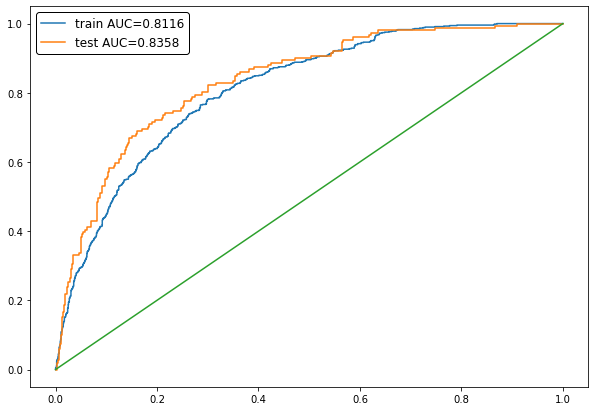

In [41]:
roc_auc_plot(y_train, y_train_predicted_gaus_nb, y_val, y_val_predicted_gaus_nb)

## Support Vector Machines

In [42]:
from sklearn.svm import SVC

In [43]:
svc_model = SVC(probability=True)

In [44]:
svc_model.fit(x_train, y_train)

SVC(probability=True)

In [45]:
y_train_predicted_svc = svc_model.predict_proba(x_train)[:, 1]
y_val_predicted_svc = svc_model.predict_proba(x_val)[:, 1]

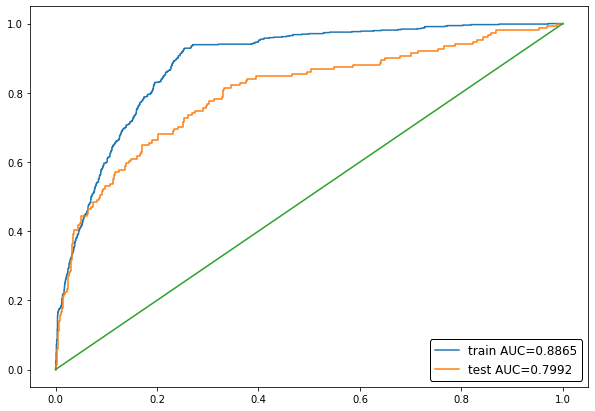

In [46]:
roc_auc_plot(y_train, y_train_predicted_svc, y_val, y_val_predicted_svc)

# Тест

In [47]:
new_test = ohe_fix(fix_columns(test))
new_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2113 entries, 0 to 2112
Data columns (total 45 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ClientPeriod               2113 non-null   float64
 1   MonthlySpending            2113 non-null   float64
 2   IsSeniorCitizen            2113 non-null   float64
 3   TotalSpent                 2113 non-null   float64
 4   Sex0                       2113 non-null   float64
 5   Sex1                       2113 non-null   float64
 6   HasPartner0                2113 non-null   float64
 7   HasPartner1                2113 non-null   float64
 8   HasChild0                  2113 non-null   float64
 9   HasChild1                  2113 non-null   float64
 10  HasPhoneService0           2113 non-null   float64
 11  HasPhoneService1           2113 non-null   float64
 12  HasMultiplePhoneNumbers0   2113 non-null   float64
 13  HasMultiplePhoneNumbers1   2113 non-null   float

In [48]:
test_id = test['id']
test = test[num_cols]

In [49]:
y_test_predicted_grad = xgbc.predict_proba(new_test)[:, 1]

In [50]:
y_test_predicted_grad = xgbc.predict_proba(new_test)[:, 1]

In [51]:
def create_submission(id_col, y_pred):
    submission = pd.DataFrame({
        'id': id_col,
        'Churn': y_pred
    })
    return submission

In [52]:
sub = create_submission(test_id, y_test_predicted_grad)
sub.to_csv("sub.csv", index=False)